# HW 05 - Taming Text

## BONUS

### Build the communication graph (unweighted and undirected) among the different email senders and recipients using the `NetworkX` library. Find communities in this graph with `community.best_partition(G)` method from the community detection module. Print the most frequent 20 words used by the email authors of each community. Do these word lists look similar to what you've produced at step 3 with LDA? Can you identify clear discussion topics for each community? Discuss briefly the obtained results.

In [5]:
import pandas as pd
import nltk
import pickle
from gensim.models.ldamodel import LdaModel
from gensim import corpora
from nltk.stem import WordNetLemmatizer

%matplotlib inline
import matplotlib.pyplot as plt

/home/weizhang/.local/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


First we import the necessary modules.

In [6]:
import community
import networkx as nx

### Simple example

Let's try the example from http://perso.crans.org/aynaud/communities/index.html:

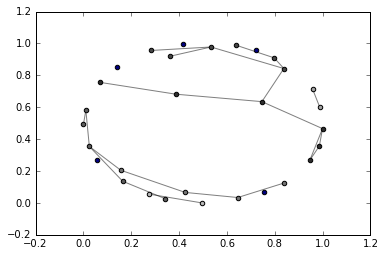

In [7]:
import matplotlib.pyplot as plt

#better with karate_graph() as defined in networkx example.
#erdos renyi don't have true community structure
G = nx.erdos_renyi_graph(30, 0.05)

#first compute the best partition
partition = community.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.show()

### Scouting useful info from the emails corpus

In [8]:
import pandas as pd

emails = pd.read_csv('hillary-clinton-emails/Emails.csv')
emails.set_index(["Id"], drop=True, inplace=True)
print(emails.shape)
emails.ix[:5,:11]

(7945, 21)


,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,MetadataDocumentClass,ExtractedSubject
Id,,,,,,,,,,,
1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,HRC_Email_296,FW: Wow
2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,HRC_Email_296,NaN
3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,HRC_Email_296,Re: Chris Stevens
4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,HRC_Email_296,FVV: Cairo Condemnation - Final
5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,HRC_Email_296,NaN


In [9]:
emails.ix[:5,11:]

,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
Id,,,,,,,,,,
1,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
2,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
3,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
5,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


In addition to the `Emails.csv` that we have seen in the three exercises, we have three other files containing information about the senders and receivers.

In [21]:
emails.columns

Index(['DocNumber', 'MetadataSubject', 'MetadataTo', 'MetadataFrom',
       'SenderPersonId', 'MetadataDateSent', 'MetadataDateReleased',
       'MetadataPdfLink', 'MetadataCaseNumber', 'MetadataDocumentClass',
       'ExtractedSubject', 'ExtractedTo', 'ExtractedFrom', 'ExtractedCc',
       'ExtractedDateSent', 'ExtractedCaseNumber', 'ExtractedDocNumber',
       'ExtractedDateReleased', 'ExtractedReleaseInPartOrFull',
       'ExtractedBodyText', 'RawText'],
      dtype='object')

In [10]:
persons = pd.read_csv('hillary-clinton-emails/Persons.csv')
persons.set_index(["Id"], drop=True, inplace=True)
print(len(persons))
persons.head(15)

513


,Name
Id,
1,111th Congress
2,AGNA USEMB Kabul Afghanistan
3,AP
4,ASUNCION
5,Alec
6,Alex Dupuy
7,American Beverage Association
8,Andrew Mayock
9,Andrew Shapiro


`Persons.csv` contains the names of all the people and organizations that are part of the email exchanges within this corpus. A unique `Id` is assigned for each person / organization.

In [11]:
aliases = pd.read_csv('hillary-clinton-emails/Aliases.csv')
aliases.set_index(["Id"], drop=True, inplace=True)
print(len(aliases))
print(len(aliases.PersonId.unique()))
aliases.head(15)

850
513


,Alias,PersonId
Id,,
1,111th congress,1
2,agna usemb kabul afghanistan,2
3,ap,3
4,asuncion,4
5,alec,5
6,dupuy alex,6
7,american beverage association,7
8,mayock andrew,8
9,shapiro andrew j,9


`Aliases.csv` contains the different ways in which a person or organization from `Persons.csv` might appear in the email corpus. Using `unique()` we can validate that their are 513 unique `PersonId`s corresponding to the number of `Id`'s in `Persons.csv`.

In [121]:
receivers.head()

,EmailId,PersonId
Id,,
1,1,80
2,2,80
3,3,228
4,3,80
5,4,80


In [118]:
receivers[receivers.EmailId == 1] #loc[1]#.PersonId

KeyError: 0

In [13]:
receivers = pd.read_csv('hillary-clinton-emails/EmailReceivers.csv')
receivers.set_index(["Id"], drop=True, inplace=True)
print(len(receivers))
print(len(receivers.EmailId.unique()))
print(len(receivers.PersonId.unique()))
receivers.head(15)

9306
7676
418


,EmailId,PersonId
Id,,
1,1,80
2,2,80
3,3,228
4,3,80
5,4,80
6,5,81
7,6,185
8,7,80
9,8,81


Out of the 7945 emails, `EmailReceivers.csv` has identified the receivers for 7676. This is great but unforunately we do not have such a table for the emails authors in order to build the graph. We'll have to extract this information from the `Emails.csv` file. From `Emails.csv`, we can use the columns `MetadataTo`, `MetadataFrom`, `ExtractedTo`, `ExtractedFrom`, and `ExtractedCc` to extract information for our graph.

Just as a check, let's make sure than `PersonId` refers to Hillary since it seems to appear a lot in above preview.

In [14]:
persons.loc[80][0]

'Hillary Clinton'

### Dictionary to map to nodes

In [15]:
to_node = {}
for index, row in aliases.iterrows():
    node_id = row.PersonId
    node = persons.loc[node_id][0]
    to_node[node_id] = node
    to_node[row.Alias] = node
    
    # use "Last Name, First Name"
    names = node.split()
    if len(names) == 2:
        to_node[names[1]+", "+names[0]] = node
len(set(to_node.values()))

513

In [16]:
# manual entries
to_node["H"] = 'Hillary Clinton'

### Extracting the nodes

Our nodes will be the authors and recipients; we will extract them from the `MetadataTo`, `MetadataFrom`, `ExtractedTo`, `ExtractedFrom`, and `ExtractedCc` columns of `Emails.csv` and the other three files.

Let's see how these fields are filled with data so that we can figure out how to parse the names.

In [17]:
nodes = []
for index, row in emails.iterrows():
    
    if index > 100: #print first 100 emails
        break
        
    print("EMAIL %d" % index)
    print("Receivers:")
    print(row.MetadataTo)
    print(row.ExtractedTo)
    recv = list(receivers[receivers.EmailId==index].PersonId)
    print([persons.loc[p][0] for p in recv])
    print()
    
    print("CC'ed:")
    print(row.ExtractedCc)
    print()
    
    print("Author")
    print(row.MetadataFrom)
    print(row.ExtractedFrom)
    print()
    
    print("---------------------------------")

EMAIL 1
Receivers:
H
nan
['Hillary Clinton']

CC'ed:
nan

Author
Sullivan, Jacob J
Sullivan, Jacob J <Sullivan11@state.gov>

---------------------------------
EMAIL 2
Receivers:
H
nan
['Hillary Clinton']

CC'ed:
nan

Author
nan
nan

---------------------------------
EMAIL 3
Receivers:
;H
B6
['b6', 'Hillary Clinton']

CC'ed:
Abedin, Huma

Author
Mills, Cheryl D
Mills, Cheryl D <MillsCD@state.gov>

---------------------------------
EMAIL 4
Receivers:
H
nan
['Hillary Clinton']

CC'ed:
Mitchell, Andrew B

Author
Mills, Cheryl D
Mills, Cheryl D <MillsCD@state.gov>

---------------------------------
EMAIL 5
Receivers:
Abedin, Huma
nan
['Huma Abedin']

CC'ed:
nan

Author
H
nan

---------------------------------
EMAIL 6
Receivers:
Russorv@state.gov
nan
['Robert Russo']

CC'ed:
nan

Author
H
nan

---------------------------------
EMAIL 7
Receivers:
H
nan
['Hillary Clinton']

CC'ed:
nan

Author
Mills, Cheryl D
Mills, Cheryl D <MillsCD@state.gov>

---------------------------------
EMAIL 8
Receive

Some observations:

* `MetadataFrom` seems more dependable for extracting the author (`H` seems to be an alternative form of refering to Hillary Clinton)
* `ExtractedCc` can be used to obtain additional people in the email conversation
* `EmailReceivers.csv` seems to be the most useful resource to obtain the receivers (also with its entries we have a usefull way of mapping emails / aliases to the full name)

So from these "resources" will create a DataFrame with three columns, where each row will represent an edge in our graph. The columns will be:

1. EmailId : corresponding to the `Id` of `Emails.csv`
2. Author : obtained from `MetadataFrom` of `Emails.csv`
3. Receiver : one of the receivers from `EmailReceivers.csv` and `ExtractedCc`

The nodes will be Author and Receiver.

In [18]:
columns = ['EmailId','Author', 'Receiver']
df_graph = pd.DataFrame(columns=columns)
num_entries = 0

for email_id, row in emails.iterrows():

    sender_id = row.SenderPersonId
    if not pd.isnull(sender_id):
        author = to_node[sender_id]
    else:
        continue # won't be able to use it to build the graph
    
    # obtain all recipients
    recp_ids = list(receivers[receivers.EmailId==email_id].PersonId)
#     recp = [persons.loc[p][0] for p in recp_ids]
    recp = [to_node[p] for p in recp_ids]
    
#     cced = row.ExtractedCc
#     try: # if multiple, recipients are separated by ";"
#         cced = cced.split(";")
#         cced = [p.lstrip(' ') for p in cced]
#     except:
#         cced = list([cced])
    
#     # try converting to node name
#     num_cc = len(cced)
#     for idx in range(num_cc):
#         try:
#             cced[idx] = to_node[cced[idx]]
#         except: pass
    
#     # remove duplicates
#     recp_cced = list(set(recp + cced))
    
    for receiver in recp:
        df_graph.loc[num_entries] = [int(email_id), author, receiver]
        num_entries += 1

In [19]:
df_graph.dropna(inplace=True)
df_graph.head()

,EmailId,Author,Receiver
0,1.0,Jake Sullivan,Hillary Clinton
1,3.0,Cheryl Mills,b6
2,3.0,Cheryl Mills,Hillary Clinton
3,4.0,Cheryl Mills,Hillary Clinton
4,5.0,Hillary Clinton,Huma Abedin


In [44]:
df_graph.shape

(9273, 3)

In [47]:
len(df_graph.Receiver.value_counts())

413

In [20]:
df_graph.Receiver.value_counts()

Hillary Clinton                5567
Huma Abedin                     720
Jake Sullivan                   483
Cheryl Mills                    452
Lauren Jiloty                   267
valmorou@state.gov              169
Lona Valmoro                    168
Philippe Reines                 116
millscd@state.gov.               54
Sidney Blumenthal                51
Lissa Muscatine                  50
Monica Hanley                    48
Anne-Marie Slaughter             47
Richard Verma                    43
Jacob Lew                        36
Robert Russo                     34
sullivanjj@state.gov.            29
oscar flores                     27
Melanne Verveer                  25
jilotylc@state.gov.              19
Kris Balderston                  18
Oscar Flores                     18
Judith McHale                    17
sullivanij@state.gov             15
Strobe Talbott                   14
James Steinberg                  14
doug band                        13
Capricia Marshall           

Create nodes of the graph, use name as a node.

In [33]:
persons = set()
for email_id, row in df_graph.iterrows():
    #print(id, row.Author, row.Receiver)
    persons.add(row.Author)
    persons.add(row.Receiver)

In [34]:
G = nx.Graph()
for person in persons:
    G.add_node(person)

In [36]:
for email_id, row in df_graph.iterrows():
    G.add_edge(row.Author, row.Receiver)

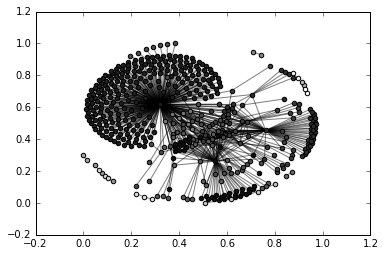

In [37]:
#G = df_graph

#first compute the best partition
partition = community.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.show()

Create nodes of the graph, use name as a node.

In [50]:
# given partition: name -> community
# build community_id -> names
community_to_persons = {}
for person, community_id in partition.items():
    if community_id not in community_to_persons:
        community_to_persons[community_id] = set()
    else:
        community_to_persons[community_id].add(person)

In [57]:
for community_id, persons in community_to_persons.items():
    print('community ' + str(community_id) + ', number of people: ' + str(len(persons)))

community 0, number of people: 42
community 1, number of people: 237
community 2, number of people: 48
community 3, number of people: 41
community 4, number of people: 40
community 5, number of people: 22
community 6, number of people: 1
community 7, number of people: 6
community 8, number of people: 1
community 9, number of people: 2
community 10, number of people: 1
community 11, number of people: 1
community 12, number of people: 3
community 13, number of people: 2
community 14, number of people: 2
community 15, number of people: 1
community 16, number of people: 1


Print the most frequent 20 words used by the email authors of each community.

In [97]:
from collections import Counter

In [128]:
emails_with_receivers = pd.merge(emails, receivers, how="inner", left_index=True, right_on='EmailId')

In [130]:
community_to_emails = {}
for community_id in community_to_persons.keys():
    community_to_emails[community_id] = ""

In [135]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
local_stop = {"re", "fw", "cc", "also", "pm", "am", "btw", "fyi", "to", "from", "nan"}
stop_words = stop_words | local_stop

In [136]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [142]:
def preprocess(text):
    # 1. tokenlization
    tokens = nltk.word_tokenize(text)
    
    # 2. remove tokens whose length <= 2
    tokens_not_short = [t for t in tokens if len(t) > 2]

    # 3. lowercase tokens
    tokens_lowercased = [t.lower() for t in tokens_not_short]
    
    # 4. remove tokens without a leading letter
    tokens_started_with_letter = [t for t in tokens_lowercased if t[0].isalpha()] 

    # 5. remove stop words 
    tokens_without_stop_words = [t for t in tokens_started_with_letter if t not in stop_words]
    
    # 6. stemming
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(t) for t in tokens_without_stop_words]
    
    return lemmatized_tokens

In [143]:
commutity_to_freq_words = {}
for community_id, people in community_to_persons.items():
    counter = Counter()
    for id, row in emails_with_receivers.iterrows():
        if pd.notnull(row.SenderPersonId):
            author = to_node[int(row.SenderPersonId)]
            receiver = to_node[row.PersonId]
            if (author in people) and (receiver in people):
                tokens = preprocess(str(row.ExtractedBodyText))
                for token in tokens:
                    counter[token] = counter[token] + 1

    print("community " + str(community_id) + ", number of people: " + str(len(people)))                
    print(counter.most_common(20))
    print()

community 0, number of people: 42
[('call', 21), ("n't", 18), ('hrc', 15), ('know', 14), ('yes', 11), ('oscar', 11), ('meeting', 10), ('a/s', 9), ('would', 9), ('yet', 8), ('tomorrow', 8), ('min', 8), ('print', 8), ('work', 7), ('good', 7), ('camera', 6), ('pooled', 6), ('heard', 6), ('confirmed', 6), ('press', 6)]

community 1, number of people: 237
[('state', 168), ('would', 107), ('official', 91), ('time', 87), ("n't", 83), ('department', 83), ('clinton', 79), ('know', 77), ('see', 72), ('need', 71), ('call', 67), ('china', 65), ('get', 64), ('work', 64), ('let', 63), ('intergovernmental', 60), ('woman', 60), ('national', 57), ('think', 57), ('obama', 57)]

community 2, number of people: 48
[('cdm', 26), ('president', 18), ('security', 17), ('aid', 17), ('one', 17), ('government', 17), ('haiti', 16), ('jones', 15), ('would', 15), ('many', 14), ('state', 14), ("n't", 14), ('blair', 13), ('secretary', 13), ('may', 12), ('need', 12), ('policy', 12), ('first', 12), ('european', 12), ('a